# 1D glacier geometry tests 

These are just a couple of sensitivity analyses to see if I understand the method presented by Huss & Farinotti 2012.

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import oggm.cfg as cfg
from scipy.stats import binned_statistic
from oggm import tasks, utils, workflow
from oggm.workflow import execute_entity_task
import matplotlib.pyplot as plt
# Ignore deprecation or NaN warnings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_context('talk')

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='CRITICAL')
# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('test_Huss')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR
# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = False
# How many grid points around the glacier?
cfg.PARAMS['border'] = 10
# Get the RGI glaciers for the run, Hintereisferner and Aletsch 
rgidf = utils.get_rgi_glacier_entities(['RGI60-11.00897', 'RGI60-11.01450'])

In [3]:
# Go - initialize glacier directory
gdirs = workflow.init_glacier_regions(rgidf)
workflow.execute_entity_task(tasks.glacier_masks, gdirs)
workflow.execute_entity_task(tasks.compute_centerlines, gdirs)
workflow.execute_entity_task(tasks.initialize_flowlines, gdirs)
rgi_stats = utils.compile_glacier_statistics(gdirs)

In [4]:
rgi_stats.T

rgi_id,RGI60-11.00897,RGI60-11.01450
rgi_region,11,11
rgi_subregion,11-01,11-01
name,Hintereisferner,
cenlon,10.7584,8.01919
cenlat,46.8003,46.5028
rgi_area_km2,8.036,82.206
glacier_type,Glacier,Glacier
terminus_type,Land-terminating,Land-terminating
status,Glacier or ice cap,Glacier or ice cap
perc_invalid_flowline,0.172727,0


## Test the method on Aletsch 

In [5]:
gdir = gdirs[1]

In [6]:
ds = xr.open_dataset(gdir.get_filepath('gridded_data'))

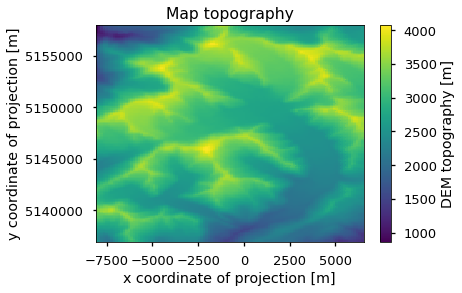

In [7]:
ds.topo.plot();
plt.title('Map topography');

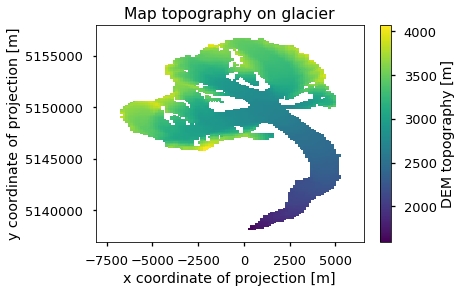

In [8]:
ds.topo.where(ds.glacier_mask == 1).plot();
plt.title('Map topography on glacier');

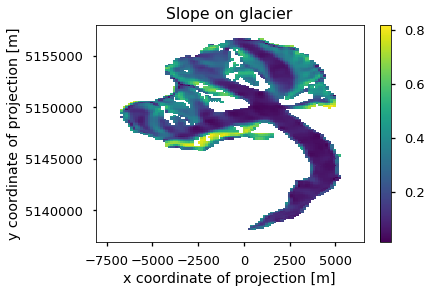

In [9]:
# 2D slope
sy, sx = np.gradient(ds['topo_smoothed'], gdir.grid.dx)
ds['slope'] = ('y', 'x'), np.arctan(np.sqrt(sx ** 2 + sy ** 2))
ds.slope.where(ds.glacier_mask == 1).plot();
plt.title('Slope on glacier');

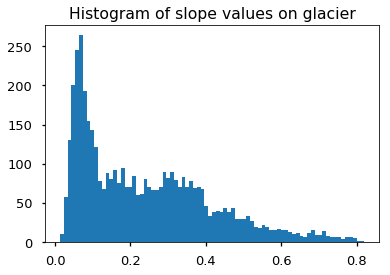

In [10]:
# elev and slope on glacier
z = ds['topo_smoothed'].data[ds['glacier_mask'] == 1]
s = ds['slope'].data[ds['glacier_mask'] == 1]
plt.hist(s, bins=80);
plt.title('Histogram of slope values on glacier');

In [11]:
# Elevation bins
z0 = utils.nicenumber(z.min(), 10, lower=True)
z1 = utils.nicenumber(z.max(), 10, lower=False)
bins = np.arange(z0, z1+1, 10)

# Binned stats
a_i, _, _ = binned_statistic(z, s, bins=bins, statistic='mean')
z_i, _, _ = binned_statistic(z, z, bins=bins, statistic='mean')
s_i, _, _ = binned_statistic(z, s, bins=bins, statistic='count')
s_i *= gdir.grid.dx**2
l_i = 10 / np.tan(a_i) 
w_i = s_i / l_i

In [12]:
print('Number of empty bins: {}'.format(np.sum(np.isnan(a_i))))
print('Average band length: {}'.format(np.nanmean(l_i)))

Number of empty bins: 11
Average band length: 64.66239675142177


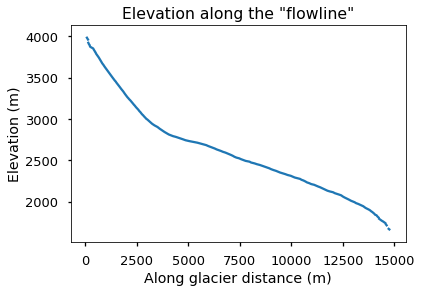

In [13]:
plt.plot(np.nancumsum(l_i[::-1]), z_i[::-1]);
plt.title('Elevation along the "flowline"');
plt.xlabel('Along glacier distance (m)');
plt.ylabel('Elevation (m)');

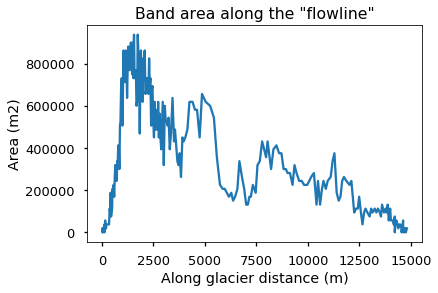

In [14]:
plt.title('Band area along the "flowline"');
plt.xlabel('Along glacier distance (m)');
plt.ylabel('Area (m2)');
plt.plot(np.nancumsum(l_i[::-1]), s_i[::-1]);

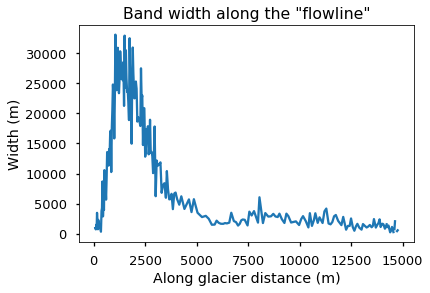

In [15]:
plt.title('Band width along the "flowline"');
plt.xlabel('Along glacier distance (m)');
plt.ylabel('Width (m)');
plt.plot(np.nancumsum(l_i[::-1]), w_i[::-1]);

## Systematic sensitivity analysis: map resolution and smoothing strength 

In [16]:
grid_dx = np.arange(10, 151, 10)
smooth_window = [0, 100, 250]

In [17]:
df_nans = [pd.DataFrame(), pd.DataFrame()] 
df_lens = [pd.DataFrame(), pd.DataFrame()]
df_areas = [pd.DataFrame(), pd.DataFrame()]
for sw in smooth_window:
    cfg.PARAMS['smooth_window'] = float(sw)
    for dx in grid_dx:
        cfg.PARAMS['grid_dx_method'] = 'fixed'
        cfg.PARAMS['fixed_dx'] = dx

        # Go - initialize glacier directory
        gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)
        workflow.execute_entity_task(tasks.simple_glacier_masks, gdirs)
        
        for gdir, df_nan, df_len, df_area in zip(gdirs, df_nans, df_lens, df_areas):

            # Read the data
            with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
                # 2D slope
                sy, sx = np.gradient(ds['topo_smoothed'], gdir.grid.dx)
                ds['slope'] = ('y', 'x'), np.arctan(np.sqrt(sx ** 2 + sy ** 2))

                # elev and slope on glacier
                z = ds['topo_smoothed'].data[ds['glacier_mask'] == 1]
                s = ds['slope'].data[ds['glacier_mask'] == 1]

            # Elevation bins
            z0 = utils.nicenumber(z.min(), 10, lower=True)
            z1 = utils.nicenumber(z.max(), 10, lower=False)
            bins = np.arange(z0, z1+1, 10)

            # Binned stats
            a_i, _, _ = binned_statistic(z, s, bins=bins, statistic='mean')
            z_i, _, _ = binned_statistic(z, z, bins=bins, statistic='mean')
            s_i, _, _ = binned_statistic(z, s, bins=bins, statistic='count')
            s_i *= gdir.grid.dx**2
            l_i = 10 / np.tan(a_i) 
            w_i = s_i / l_i

            # Out
            f = 'Smooth_{}'.format(sw)
            df_nan.loc[dx, f] = np.sum(np.isnan(z_i))
            df_len.loc[dx, f] = np.nansum(l_i)
            df_area.loc[dx, f] = np.nansum(s_i)

### Glacier length as a function of map resolution and topo smoothing window size  

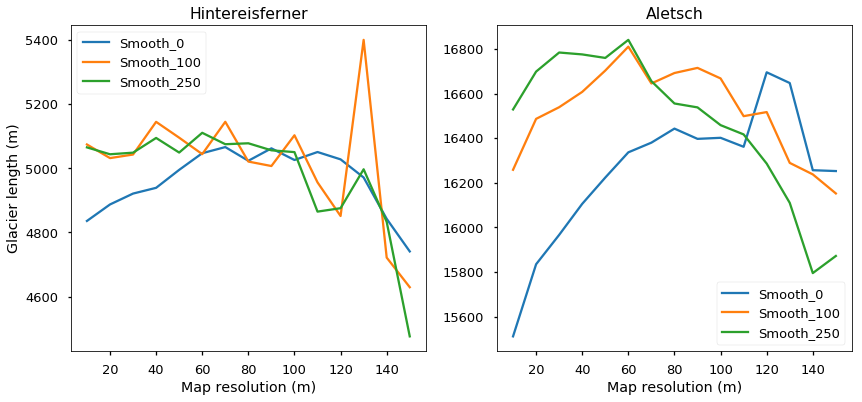

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
df_lens[0].plot(ax=ax1);
ax1.set_title('Hintereisferner')
ax1.set_xlabel('Map resolution (m)')
ax1.set_ylabel('Glacier length (m)')
df_lens[1].plot(ax=ax2);
ax2.set_title('Aletsch');
ax2.set_xlabel('Map resolution (m)');

### Number of missing bands

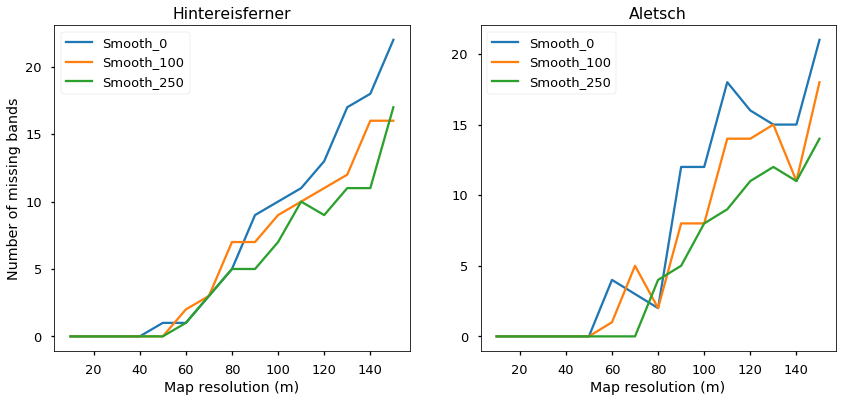

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
df_nans[0].plot(ax=ax1);
ax1.set_title('Hintereisferner')
ax1.set_xlabel('Map resolution (m)')
ax1.set_ylabel('Number of missing bands')
df_nans[1].plot(ax=ax2);
ax2.set_title('Aletsch');
ax2.set_xlabel('Map resolution (m)');